In [1]:
import os

os.chdir("..")

os.getcwd()

'c:\\Users\\mquick\\Documents\\zeitgeist blog\\projects\\political_fragmentation'

In [2]:
import pandas as pd
import re
from utils import GiniCalculator
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Collect election results data

#### Election data from 1965-2012

[Source](https://www.data.gouv.fr/fr/datasets/elections-presidentielles-1965-2012-1/)

In [3]:
election_results_links = {
    1965: "https://www.data.gouv.fr/fr/datasets/r/145d8e34-969d-4723-b279-4eeb71357cf5",
    1969: "https://www.data.gouv.fr/fr/datasets/r/21f55439-33f4-49b8-b342-fb15a740c5a6",
    1974: "https://www.data.gouv.fr/fr/datasets/r/39ad2d9a-a304-4417-b5f3-b7afe71f3f66",
    1981: "https://www.data.gouv.fr/fr/datasets/r/fc1e47fc-d30a-4f88-a5e9-98ad710c41e9",
    1988: "https://www.data.gouv.fr/fr/datasets/r/2c3ad138-f5e7-4c33-a658-5b913a9d6883",
    1995: "https://www.data.gouv.fr/fr/datasets/r/bb902209-1e3a-41f9-861b-46968f536606",
    2002: "https://www.data.gouv.fr/fr/datasets/r/f61bc72c-3f85-4660-b292-18944ebea9a6",
    2007: "https://www.data.gouv.fr/fr/datasets/r/29852f48-c30e-42ac-8996-1166ba105435",
    2012: "https://www.data.gouv.fr/fr/datasets/r/dca1e9d6-30ff-44b6-a4bc-2eec177c2121",
    2017: "https://www.data.gouv.fr/fr/datasets/r/449f02ce-e971-46a9-aa72-ca66858f16cf",
    2022: "https://www.data.gouv.fr/fr/datasets/r/1a35594a-99f2-4257-87e0-ec2f55039276"
}

In [4]:
class ResultsFormatter:
    
    def __init__(self, election_year: int) -> None:
        self.election_year = election_year
        
    def get_data_from_url(self) -> pd.DataFrame:
        if self.election_year > 2012:
            raise Exception
        return pd.read_csv(election_results_links[self.election_year])
    
    @staticmethod
    def get_candidate_names(columns: list[str]) -> list[str]:
        return [
            col
            for col in columns
            if any([
                all([
                    letter.isupper()
                    for letter in word
                    if letter.isalpha()
                    ]) for word in col.split(" ")
                ])
        ]
        
    @staticmethod
    def get_location_cols(columns: list[str]) -> list[str]:
        return [
            col
            for col in columns
            if "circonscription" in col.lower() 
            or "code" in col.lower()
        ]
        
    def get_results(self) -> pd.DataFrame:
        raw_results_df = self.get_data_from_url()
        candidates = self.get_candidate_names(raw_results_df.columns)
        location_cols = self.get_location_cols(raw_results_df.columns)
        index_cols = location_cols + ["Exprimés"]
        results_df = raw_results_df[index_cols + candidates]
        melted_results_df = results_df\
            .melt(id_vars=index_cols, var_name="candidate", value_name="votes_total")\
            .assign(election_year = self.election_year)
        melted_results_df["votes_pct"] = (melted_results_df["votes_total"] / melted_results_df["Exprimés"]) * 100
        melted_results_df.rename(columns={
            melted_results_df.columns[0]: "departement",
            melted_results_df.columns[1]: "circonscription",
        }, inplace=True)
        return melted_results_df

In [5]:
elections_df = pd.concat([
    ResultsFormatter(year).get_results()
    for year in list(election_results_links.keys())[:-2]
])

In [6]:
elections_df[elections_df.isna().any(axis=1)]

,departement,circonscription,Exprimés,candidate,votes_total,election_year,votes_pct


#### 2017 and 2022 election data

##### 2017

In [7]:
results_2017_df = pd.read_excel(election_results_links[2017], header=3, sheet_name="Circo. Leg. Tour 1")

In [8]:
index_cols = ["Code du département", "Code de la circonscription", "Exprimés"]

In [9]:
results_2017_df = results_2017_df[index_cols + [col for col in results_2017_df.columns if col.startswith("Nom") or col.startswith("Voix")]]

In [10]:
n_candidates = len([col for col in results_2017_df.columns if col.startswith("Nom")])

In [11]:
all_candidates_df = results_2017_df.iloc[:, :5]

for i in range(1, n_candidates):
    n_place_df = results_2017_df[index_cols + [f"Nom.{i}", f"Voix.{i}"]]
    n_place_df = n_place_df.rename(columns={
        col: col.replace(f".{i}", "").strip()
        for col in n_place_df.columns
        })
    all_candidates_df = pd.concat([all_candidates_df, n_place_df])

In [12]:
elections_df.columns

Index(['departement', 'circonscription', 'Exprimés', 'candidate',
       'votes_total', 'election_year', 'votes_pct'],
      dtype='object')

In [13]:
all_candidates_df["votes_pct"] = (all_candidates_df["Voix"] / all_candidates_df["Exprimés"]) * 100

In [14]:
all_candidates_df = all_candidates_df.rename(columns={
    "Code du département": "departement",
    "Code de la circonscription": "circonscription",
    "Nom": "candidate",
    "Voix": "votes_total"
})\
    .assign(election_year = 2017)

##### 2022

In [15]:
results_2022_df = pd.read_excel(election_results_links[2022])

In [16]:
cols = [col for col in results_2022_df.columns if not col.startswith("Unnamed")]
cols

['Code du département',
 'Libellé du département',
 'Code de la circonscription',
 'Libellé de la circonscription',
 'Etat saisie',
 'Inscrits',
 'Abstentions',
 '% Abs/Ins',
 'Votants',
 '% Vot/Ins',
 'Blancs',
 '% Blancs/Ins',
 '% Blancs/Vot',
 'Nuls',
 '% Nuls/Ins',
 '% Nuls/Vot',
 'Exprimés',
 '% Exp/Ins',
 '% Exp/Vot',
 'N°Panneau',
 'Sexe',
 'Nom',
 'Prénom',
 'Voix',
 '% Voix/Ins',
 '% Voix/Exp']

In [17]:
repeated_cols = cols[-7:]

In [18]:
n_unnamed_candidates = len([col for col in results_2022_df.columns if col.startswith("Unnamed")])
n_iterations = n_unnamed_candidates / len(repeated_cols)

In [19]:
start = cols.index(repeated_cols[0]) + len(repeated_cols)

In [20]:
for i in range(int(n_iterations)):
    for j, col in enumerate(repeated_cols):
        col_index = start + j
        results_2022_df = results_2022_df.rename(columns={results_2022_df.columns[col_index]: f"{col}_{i}"})
    start += len(repeated_cols)

In [21]:
index_cols = ["Code du département", "Code de la circonscription", "Exprimés"]

In [22]:
results_2022_df = results_2022_df[index_cols + [col for col in results_2022_df.columns if col.startswith("Nom") or col.startswith("Voix")]]

In [23]:
all_candidates_2022_df = results_2022_df.iloc[:, :5]

for i in range(int(n_iterations)):
    n_place_df = results_2022_df[index_cols + [f"Nom_{i}", f"Voix_{i}"]]
    n_place_df = n_place_df.rename(columns={
        col: col.replace(f"_{i}", "").strip()
        for col in n_place_df.columns
        })
    all_candidates_2022_df = pd.concat([all_candidates_2022_df, n_place_df])

In [24]:
all_candidates_2022_df["votes_pct"] = (all_candidates_2022_df["Voix"] / all_candidates_2022_df["Exprimés"]) * 100

In [25]:
all_candidates_2022_df = all_candidates_2022_df.rename(columns={
    "Code du département": "departement",
    "Code de la circonscription": "circonscription",
    "Nom": "candidate",
    "Voix": "votes_total"
})\
    .assign(election_year = 2022)

##### Merge election results datasets

In [26]:
elections_df = pd.concat([
    elections_df,
    all_candidates_df,
    all_candidates_2022_df
])

### Calculate gini coefficient

* By candidate
* By election
* Look at difference in results by taking circonscription- and departement-level results

In [27]:
calculator = GiniCalculator()

In [28]:
circ_candidate_gini_df = calculator.gini_coeff_by_candidate(election_results_df=elections_df)
circ_candidate_gini_df.rename(columns={"gini_coeff":"circonscription"}, inplace=True)

In [29]:
departement_elections_df = elections_df\
    .drop("votes_pct", axis=1)\
    .groupby(["election_year", "departement", "candidate"], as_index=False)\
    .agg(exprimes = ("Exprimés", "sum"),
         votes_total = ("votes_total", "sum")
         )
    
departement_elections_df["votes_pct"] = (departement_elections_df["votes_total"]/departement_elections_df["exprimes"]) * 100

In [30]:
dep_candidate_gini_df = calculator.gini_coeff_by_candidate(election_results_df=departement_elections_df)
dep_candidate_gini_df.rename(columns={"gini_coeff":"departement"}, inplace=True)

In [32]:
index_cols = ["election_year", "candidate"]

In [44]:
candidate_gini_df = circ_candidate_gini_df.merge(dep_candidate_gini_df.drop("votes_total", axis=1),
                             on=index_cols,
                             how="inner"
                             )

In [45]:
candidate_gini_df["diff"] = candidate_gini_df["circonscription"] - candidate_gini_df["departement"]

In [47]:
candidate_gini_df["rank"] = candidate_gini_df.groupby("election_year", as_index=False)["votes_total"].rank(ascending=False)

In [58]:
candidate_gini_df["candidate_year"] = candidate_gini_df.apply(lambda x: f"{x['candidate']}, {x['election_year']}", axis=1)

<Axes: xlabel='diff', ylabel='candidate_year'>

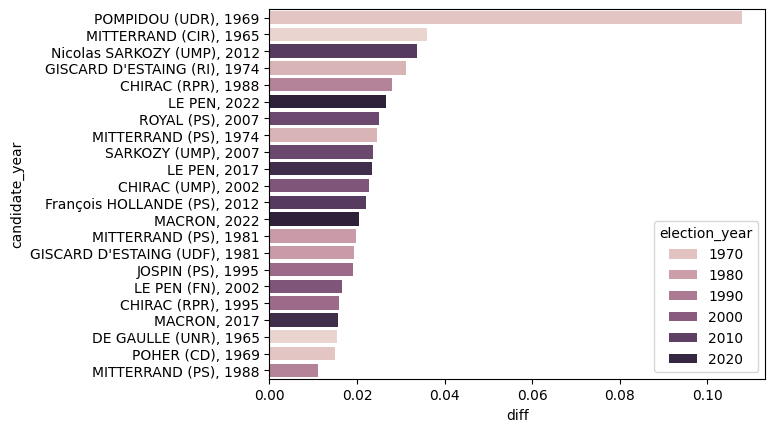

In [59]:
sns.barplot(
    data = candidate_gini_df\
    .loc[candidate_gini_df["rank"]<=2]\
    .sort_values("diff", ascending=False),
    x = "diff",
    y="candidate_year",
    hue="election_year"
)

In [67]:
melted_gini_df = candidate_gini_df\
    .drop(["rank", "candidate_year", "diff"], axis=1)\
    .melt(id_vars=index_cols+["votes_total"], 
          var_name="level", value_name="gini_coeff")

In [69]:
election_gini_df = calculator.gini_coeff_by_election(melted_gini_df, group_by_cols=["election_year", "level"])

In [72]:
np.corrcoef(x=election_gini_df.loc[election_gini_df["level"]=="circonscription", "gini_coeff"],
            y=election_gini_df.loc[election_gini_df["level"]=="departement", "gini_coeff"]
            )

array([[1.        , 0.81415596],
       [0.81415596, 1.        ]])

<Axes: xlabel='election_year', ylabel='gini_coeff'>

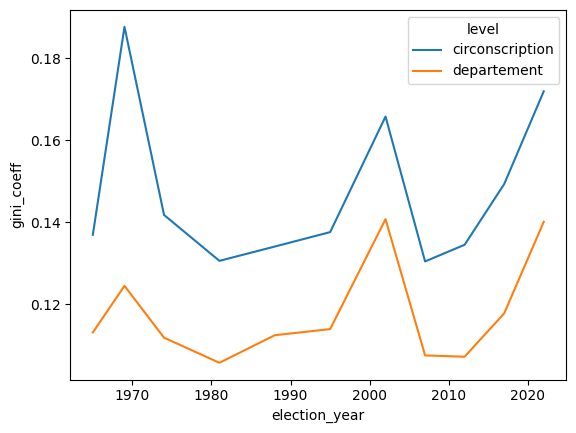

In [71]:
sns.lineplot(data=election_gini_df, x="election_year", y="gini_coeff", hue="level")